In [3]:
#Importar librerías
import pandas as pd
import pyodbc
from sqlalchemy import create_engine
import networkx as nx 
import matplotlib.pyplot as plt

In [4]:
##configuración de la conección
server = 'PAUTGSQLP47'
database = 'CONTROL_PROCESOS_COMP'
trusted_connection = 'yes' # esto indica que se usará la autentificación de windows
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection={trusted_connection}'
conn = pyodbc.connect(connection_string)
engine  = create_engine(f'mssql+pyodbc:///?odbc_connect={connection_string}')
cursor = conn.cursor()

In [5]:
esquema_filtro = "APP_PdD"

if esquema_filtro == "":
    query_tablas = """
        SELECT SCHEMA_NAME(schema_id) as schema_name, name as table_name , sum(rows) as row_count
        FROM sys.tables t
        inner join sys.partitions p ON t.object_id = p.object_id
        where p.index_id IN (0,1) 
        group by SCHEMA_NAME(schema_id),name"""
else:
    query_tablas = f"""
        SELECT SCHEMA_NAME(schema_id) as schema_name, name as table_name , sum(rows) as row_count
        FROM sys.tables t
        inner join sys.partitions p ON t.object_id = p.object_id
        where p.index_id IN (0,1) and SCHEMA_NAME(schema_id) = '{esquema_filtro}'
        group by SCHEMA_NAME(schema_id),name"""

In [6]:
#Obtener la lista de las tablas en la BD
tabla_cursor = conn.cursor()
tabla_cursor.execute(query_tablas)
tablas = tabla_cursor.fetchall()
tablas

[('APP_PdD', 'BASE_ELEGIBLES', 7347),
 ('APP_PdD', 'BASE_ELEGIBLES_ROBUSTA', 7347),
 ('APP_PdD', 'BASE_ENVIO', 64604),
 ('APP_PdD', 'BASE_ENVIO_CORREO', 767550),
 ('APP_PdD', 'BASE_ENVIOF', 64469),
 ('APP_PdD', 'BASE_ENVIOFF', 64469),
 ('APP_PdD', 'BASE_FLG_RETIRO', 811826),
 ('APP_PdD', 'BASE_ULTI_INDI', 811826),
 ('APP_PdD', 'BASE_ULTIMO_PERIODO', 173302),
 ('APP_PdD', 'BASE_USUARIOS_CONEXL', 134926),
 ('APP_PdD', 'BASE_USUARIOS_FINAL', 1427417),
 ('APP_PdD', 'BaseFormatoRankMi', 32566),
 ('APP_PdD', 'BaseFormatoRankMi_0612_V2', 3829),
 ('APP_PdD', 'CARGADORANKMI_0512', 97),
 ('APP_PdD', 'CargasMacroConsolida', 0),
 ('APP_PdD', 'CENTRALIZADO_XLS', 4084),
 ('APP_PdD', 'CONS_EXCEL', 20589),
 ('APP_PdD', 'CONS_EXCEL_PB', 27352),
 ('APP_PdD', 'CONS_EXCEL_PB_051223', 1924),
 ('APP_PdD', 'CONS_EXCEL_PB_2', 4194),
 ('APP_PdD', 'ConsolidaResultados', 7856),
 ('APP_PdD', 'EnviadosRankMi', 5264),
 ('APP_PdD', 'EnviadosRankMi_0612_V2', 706),
 ('APP_PdD', 'EXCLU_02AGO', 226),
 ('APP_PdD', 'EXPOR

In [7]:
#Diccionario para guardar el nombre de los df's
dataframes = {}
dataframes_vacios = {}

#Iterar sobre las tablas y cargar cada una a un df 
for tabla in tablas:
    esquema_tabla = tabla[0]
    nombre_tabla = tabla[1]
    cantidad_filas = tabla[2]
    query = f"SELECT top (10000) * FROM [{esquema_tabla}].[{nombre_tabla}]"

    #Cragar los datos 
    df = pd.read_sql(query, engine)

    #Nombre de la tabla
    nombre_df = esquema_tabla + '_' + nombre_tabla

    #Cambiar y guardar el nombre del df
    globals()[nombre_df] = df.copy()

    #Agregar nombre del df en el diccionario
    if cantidad_filas > 100:
        dataframes[nombre_df] = globals()[nombre_df]
    else:
        dataframes_vacios[nombre_df] = globals()[nombre_df]
    
    del df #Eliminar df

In [8]:
#cursor = conn.cursor()
conn.close()

In [9]:
# Crear un grafo dirigido para representar las relaciones
grafo_relaciones = nx.DiGraph()

In [10]:
# Definir función para calcular el porcentaje de similitud de los datos
def porcentaje_valores_en_comun(df1, df2, columna_df1, columna_df2):
    df1[columna_df1] = df1[columna_df1].astype(str, errors='ignore')
    df2[columna_df2] = df2[columna_df2].astype(str, errors='ignore')

    valores_unicos_df1 = set(df1[columna_df1])
    valores_unicos_df2 = set(df2[columna_df2])

    valores_en_comun = valores_unicos_df1.intersection(valores_unicos_df2)
    if len(valores_en_comun) == 0 or len(valores_unicos_df1) == 0:
        porcentaje_en_comun = 0
    else:
        porcentaje_en_comun = len(valores_en_comun) / len(valores_unicos_df1) * 100

    return porcentaje_en_comun

In [11]:
# Definir una función para inferir relaciones basándose en la similitud de Jaccard
def inferir_relaciones(df1, df2, umbral_similitud=70):
    for col1 in df1.columns:
        if 'float' in str(df1[col1].dtype):
            continue
        if len(df1[col1]) == df1[col1].nunique():
            for col2 in df2.columns:
                if 'float' in str(df2[col2].dtype):
                    continue
                if porcentaje_valores_en_comun(df1, df2, col1, col2) > umbral_similitud:
                    return col1, col2
                elif porcentaje_valores_en_comun(df2, df1, col2, col1) > umbral_similitud:
                    return col2, col1
        else:
            for col2 in df2.columns:
                if 'float' in str(df2[col2].dtype):
                    continue
                if len(df2[col2]) == df2[col2].nunique():
                    if porcentaje_valores_en_comun(df1, df2, col1, col2) > umbral_similitud:
                        return col1, col2
                    elif porcentaje_valores_en_comun(df2, df1, col2, col1) > umbral_similitud:
                        return col2, col1
        return None

In [12]:
def relaciones_entre_tablas(diccionario_tablas, tabla_especifica=None):
    # Crear un grafo dirigido para representar las relaciones
    grafo_relaciones = nx.DiGraph()
    # Inicializar el conjunto de nombres de DataFrames relacionados
    dataframes_relacionados = set()
    relaciones_comparadas = set()
    if tabla_especifica == None:
        # Iterar sobre los pares de DataFrames y buscar relaciones
        for nombre_df1, df1 in diccionario_tablas.items():
            for nombre_df2, df2 in diccionario_tablas.items():
                if nombre_df1 != nombre_df2:
                    relaciones = inferir_relaciones(df1, df2)
                    if relaciones:
                        grafo_relaciones.add_edge(nombre_df1, nombre_df2, relaciones=relaciones)
                        dataframes_relacionados.add(nombre_df1)
                        dataframes_relacionados.add(nombre_df2)
                        relaciones_comparadas.add((nombre_df1,nombre_df2))

        # Encontrar DataFrames sin relaciones y agregar nodos para ellos
        dataframes_sin_relacion = set(diccionario_tablas.keys()) - dataframes_relacionados
        for df in dataframes_sin_relacion:
            grafo_relaciones.add_node(df)

        return grafo_relaciones

    else:
        for nombre_df1, df1 in diccionario_tablas.items():
            for nombre_df2, df2 in diccionario_tablas.items():
                if nombre_df1 != nombre_df2:
                    if nombre_df1 == tabla_especifica or nombre_df2 == tabla_especifica:
                        relaciones = inferir_relaciones(df1, df2)
                        if relaciones:
                            grafo_relaciones.add_edge(nombre_df1, nombre_df2, relaciones=relaciones)
                            dataframes_relacionados.add(nombre_df1)
                            dataframes_relacionados.add(nombre_df2)
                            relaciones_comparadas.add((nombre_df1,nombre_df2))
                            
        return grafo_relaciones


In [28]:
grafo_relaciones = relaciones_entre_tablas(dataframes, 'APP_PdD_BASE_ELEGIBLES')

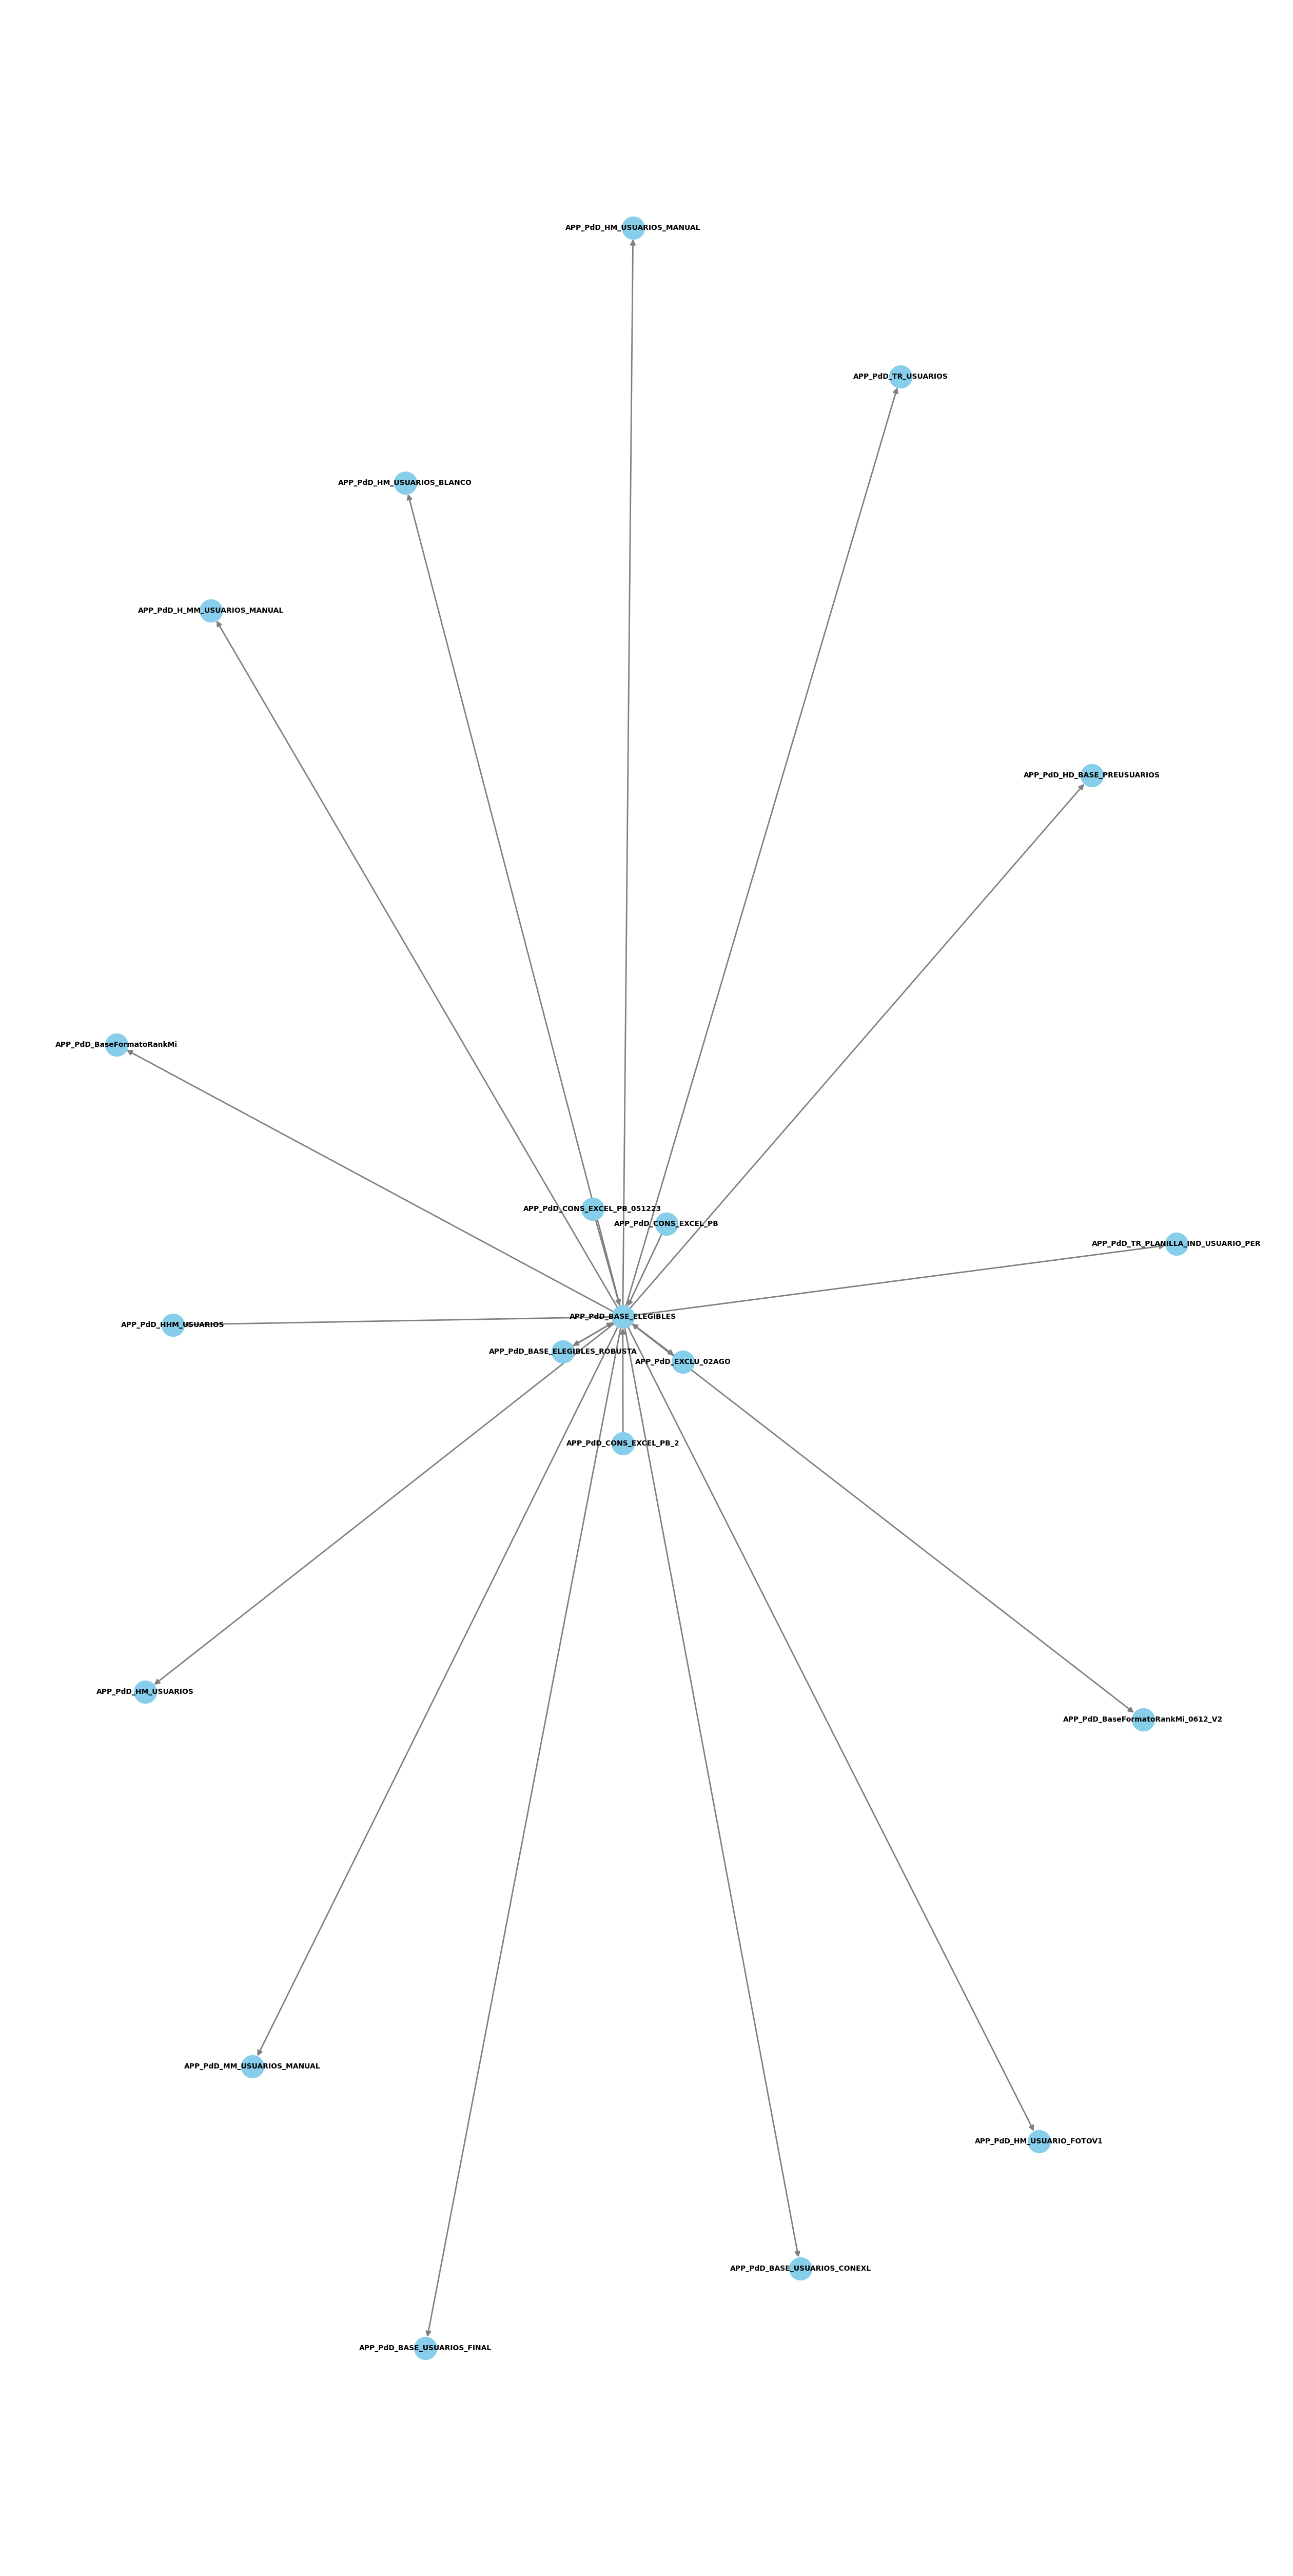

In [32]:
# Dibujar el grafo
plt.figure(figsize=(25, 50))
posiciones = nx.spring_layout(grafo_relaciones)
nx.draw(grafo_relaciones, posiciones, with_labels=True, font_weight='bold', node_size=1000, node_color="skyblue", font_size=10, edge_color="gray", width=2, arrowsize=15)
plt.show()